**Gerando o arquivo requirements.txt**

In [ ]:
!pip3 freeze > requirements.txt

# Git

In [ ]:
# clonando o repositorio

!git clone http://pdi.mobitbrasil.com.br:8601/scm/anp/estagiario-ciencia-dados.git

Cloning into 'estagiario-ciencia-dados'...
remote: Counting objects: 33, done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 10), reused 0 (delta 0)
Unpacking objects: 100% (33/33), done.


In [ ]:
%cd /content/estagiario-ciencia-dados
!git status

/content/estagiario-ciencia-dados
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

# Analisando o Banco de Dados

## 1.1 - Carregue o conjunto de dados em memória para realizar as análises.

In [ ]:
# caminho do banco de dados
path_file = '/content/estagiario-ciencia-dados/data/traffic_data.feather'
df = pd.read_feather(path_file)

In [ ]:
df

,index,passage,direction,type,region,timestamp,jam_size,segment
0,0,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...,...
5223443,230195,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


## 1.2 - Dados Nulos/Faltantes

**Gerando grafico com os valores nulos**

In [ ]:
# Fazendo uma varredura em todas as colunas e encontrando os valores Nan

nan_columns = []
nan_values = []

for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())


In [ ]:
print(nan_values)

[0, 0, 0, 3323735, 2509341, 0, 0, 0]


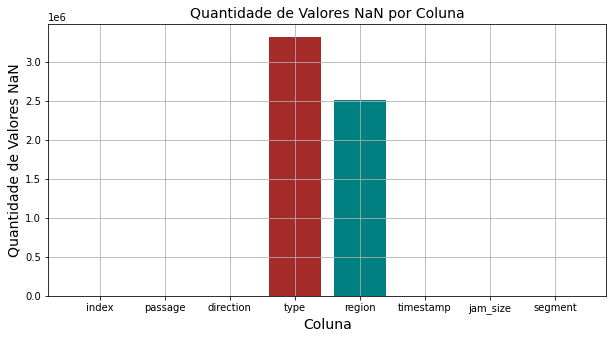

In [ ]:
New_Colors = ['green','blue','purple','brown','teal']
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(nan_columns, nan_values, color=New_Colors)
plt.title('Quantidade de Valores NaN por Coluna', fontsize=14)
plt.xlabel('Coluna', fontsize=14)
plt.ylabel('Quantidade de Valores NaN', fontsize=14)
plt.grid(True)
plt.show()

**Com este grafico é possivel notar que os valores nulos são referentes as colunas "*type*" e "*region*".**

**Tendo este problema em vista pode-se fazer as seguintes abordagens:**

1.   Substituir os valores Nan por alguma classe que os represente.
2.   Eliminar as linhas que apresentam algum valor Nan.



### Abordagem 1:

**Realizando essa abordagem o dataframe não sofrerá redução.**

In [ ]:
# Redefinindo os valores Nan da coluna "type"
# Os valores Nan irão receber a sigla "NINF" que significa "Não Informado"

df_2 = pd.read_feather(path_file)
df_2['type'] = df_2['type'].replace({np.nan: "NINF"})

In [ ]:
# Redefinindo os valores Nan da coluna "region"
# Os valores Nan irão receber a sigla "RNI" que significa "Regiao Não Informado"

df_2['region'] = df_2['region'].replace({np.nan: "RNI"})

In [ ]:
df_2['type'] = pd.Series(df_2['type'], dtype="category")
df_2['region'] = pd.Series(df_2['region'], dtype="category")

In [ ]:
# Salvando abordagem 1 (opcional)

#df_2 = df_2.reset_index()
#df_2.to_feather('df_2.feather')

### Abordagem 2:

**Realizando essa abordagem o dataframe sofrerá uma grande redução.**

In [ ]:
# Removendo todas as linhas que tem Valores Nan

df_3 = pd.read_feather(path_file)
df_3 = df_3.dropna()

In [ ]:
# Salvando abordagem 2 (opcional)

#df_3 = df_3.reset_index()
#df_3.to_feather('df_3.feather')

### Grafico Comparativo:

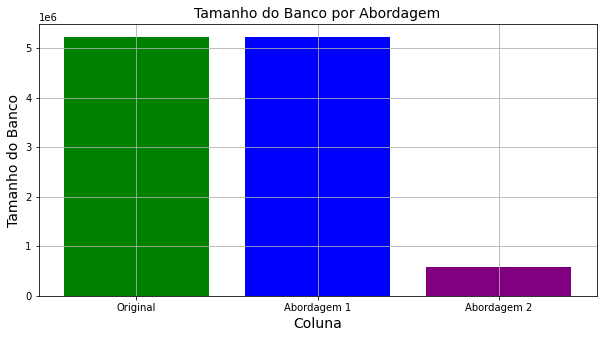

In [ ]:
New_Colors = ['green','blue','purple']
Ax = ['Original', 'Abordagem 1', 'Abordagem 2']
Ay = [len(df), len(df_2), len(df_3)]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(Ax, Ay, color=New_Colors)
plt.title('Tamanho do Banco por Abordagem', fontsize=14)
plt.xlabel('Coluna', fontsize=14)
plt.ylabel('Tamanho do Banco', fontsize=14)
plt.grid(True)
plt.show()

**Com base no grafico acima, pode-se analisar que houve uma grande redução do banco na abordagem 2. Portanto, a abordagem 1 será escolhida**

## 1.3 - Dados Categóricos

**Por quê transformar os dados categoricos em numericos?**

*Porque alguns algoritmos de Machine Learning não trabalham com dados categóricos, ou seja, não aceitam esses dados como entrada. Por exemplo, algoritmos como SVM ou uma regressão linear, somente trabalham com valores numéricos. Diante dessa limitação precisamos converter as variáveis categóricas para valores numéricos.*



In [ ]:
# Da um valor inteiro que representa o valor categorico
LE = LabelEncoder()

# Criando um dataframe com os dados categoricos
df_categ_Encoder = pd.DataFrame()

# Colunas:
# index | passage | direction | type | region | timestamp | jam_size | segment
df_categ_Encoder['index'] = df_2.index
df_categ_Encoder['passage_Encod'] = LE.fit_transform(df_2['passage'])
df_categ_Encoder['direction_Encod'] = LE.fit_transform(df_2['direction'])
df_categ_Encoder['type_Encod'] = LE.fit_transform(df_2['type'])
df_categ_Encoder['region_Encod'] = LE.fit_transform(df_2['region'])
df_categ_Encoder['timestamp'] = df_2.timestamp
df_categ_Encoder['jam_size'] = df_2.jam_size
df_categ_Encoder['jam_size_Encod'] = LE.fit_transform(df_2.jam_size)
df_categ_Encoder['segment_Encod'] = LE.fit_transform(df_2['segment'])

In [ ]:
#df_categ_Encoder.to_feather('dataframe_catego.feather')
df_categ_Encoder

,index,passage_Encod,direction_Encod,type_Encod,region_Encod,timestamp,jam_size,jam_size_Encod,segment_Encod
0,0,153,101,2,3,2015-01-04 14:30:00,799,748,99695
1,1,151,29,2,5,2015-01-04 14:30:00,260,209,533
2,2,153,101,2,3,2015-01-04 15:00:00,799,748,99695
3,3,151,29,2,5,2015-01-04 15:00:00,260,209,533
4,4,153,101,2,3,2015-01-04 15:30:00,799,748,99695
...,...,...,...,...,...,...,...,...,...
5223443,5223443,170,33,0,3,2018-09-30 18:30:00,3820,3769,75974
5223444,5223444,170,33,1,3,2018-09-30 19:00:00,4640,4587,76072
5223445,5223445,170,33,0,3,2018-09-30 19:00:00,3820,3769,75974
5223446,5223446,170,33,1,3,2018-09-30 19:30:00,4640,4587,76072


## 1.4 - Correlação

**Com os graficos de correlação é possivel observar os atributos (colunas) que melhor se relacionam e assim escolher os "melhores" para o treinamento de um modelo de machine learning.**

In [ ]:
# Criando duas colunas 'data' e 'hora'
data = []
hora = []

for i in df_categ_Encoder['timestamp']:
  i = str(i).split(' ')
  data.append(i[0])
  hora.append(i[1])

df_categ_Encoder['data'] = data
df_categ_Encoder['hora'] = hora

In [ ]:
df_categ_Encoder['hora_Encod'] = LE.fit_transform(df_categ_Encoder['hora'])
df_categ_Encoder['data_Encod'] = LE.fit_transform(df_categ_Encoder['data'])

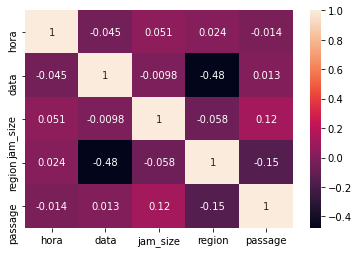

In [ ]:
# Gerando grafico de correlação entre os seguintes atributos:
# hora_Encod | data_Encod | jam_size | region_Encod | passage_Encod

data = {'hora': df_categ_Encoder['hora_Encod'],
        'data': df_categ_Encoder['data_Encod'],
        'jam_size': df_categ_Encoder['jam_size'],
        'region': df_categ_Encoder['region_Encod'],
        'passage': df_categ_Encoder['passage_Encod']
        }

# Criando um dataframe
df_corr = pd.DataFrame(data,columns=['hora', 'data', 'jam_size', 'region', 'passage'])

# Gerando a correlação
corrMatrix = df_corr.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Utilizando outro metodo para gerar o grafico de correlação
df_corr.corr(method='spearman')

,hora,data,jam_size,region,passage
hora,1.000000,-0.043102,0.024335,0.033555,-0.008648
data,-0.043102,1.000000,-0.020414,-0.443876,0.022269
jam_size,0.024335,-0.020414,1.000000,-0.043515,0.112920
region,0.033555,-0.443876,-0.043515,1.000000,-0.142341
passage,-0.008648,0.022269,0.112920,-0.142341,1.000000


In [ ]:
#df_categ_Encoder.to_csv('dataframe_Encod.csv')

**Com este grafico pode-se analisar que a coluna 'passage' se ralaciona muito bem com a 'jam_size', mas esperava-se uma relação mais 'forte' com outros atributos, como 'data' e 'hora'.**

## 1.5 - Análise de Engarrafamentos

In [ ]:
# Gerando colunas no dataframe

ano = []
mes = []
dia = []

for i in df_categ_Encoder['data']:
  i = str(i).split('-')
  ano.append(i[0])
  mes.append(i[1])
  dia.append(i[2])

df_categ_Encoder['ano'] = ano
df_categ_Encoder['mes'] = mes
df_categ_Encoder['dia'] = dia

In [ ]:
# Observando o range do atributo 'ano'

print(df_categ_Encoder['ano'].min())
print(df_categ_Encoder['ano'].max())

2001
2018


In [ ]:
## Ano
## Criando um dicionario e coletando todos os valores de 'jam_size' em um determinado ano

new_df = df_categ_Encoder
dict_data = {}

for year in range(2001,2019):
  find = new_df.loc[new_df['ano'] == str(year)]
  vet_year = []

  for i in find['jam_size']:
    vet_year.append(i)
  
  dict_data[str(year)] = vet_year

  #print(year)

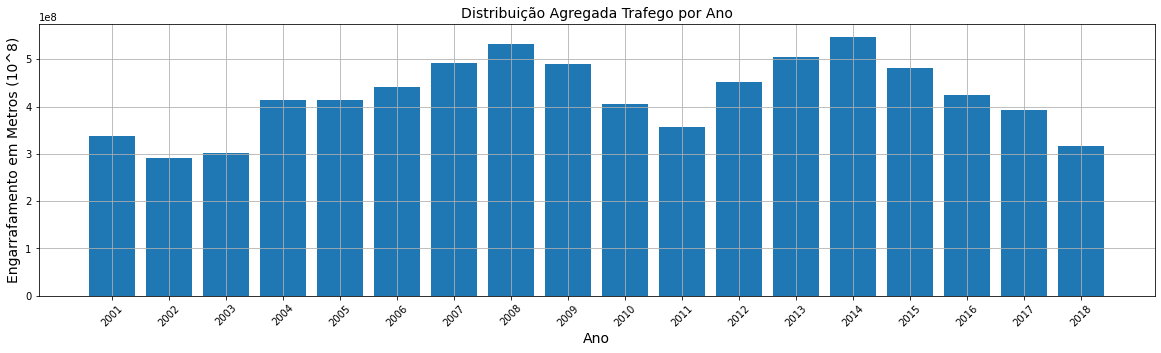

In [ ]:
# Ano (agregado)
# Somando (agregando) todos os valores de 'jam_size' em seu respectivo ano

sum_dict = {}
mean = {}

for key in dict_data:
  sum_dict[key] = sum(dict_data[key])
  mean[key] = sum(dict_data[key])/len(dict_data[key])


Ax = sum_dict.keys()
Ay = sum_dict.values()

# Plotando o grafico de barras
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(Ax, Ay)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Distribuição Agregada Trafego por Ano', fontsize=14)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Engarrafamento em Metros (10^8)', fontsize=14)
plt.grid(True)
plt.show()

**No gráfico acima é possível observar há uma taxa de crescimento no trafego de veiculos nos anos de 2002 a 2008. Isto pode ser explicado pelo fato do crescimento da frota de veiculos por causa dos incentivos fiscais.**

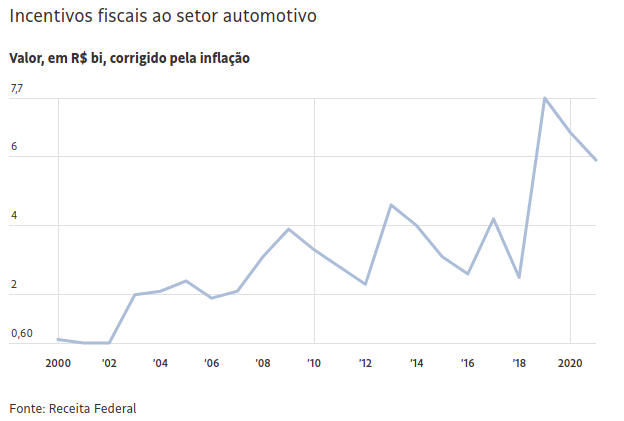


**Fonte:**https://www1.folha.uol.com.br/mercado/2021/01/incentivos-da-uniao-a-montadoras-somam-r-69-bilhoes-de-2000-a-2021.shtml#:~:text=Hoje%2C%20os%20principais%20programas%20para,f%C3%A1bricas%20instaladas%20nas%20tr%C3%AAs%20regi%C3%B5es. 

In [ ]:
## Mes
## Criando um dicionario e coletando todos os valores de 'jam_size' em um determinado mês

dict_data = {}

for month in range(1,13):
  if month < 10:
    find = df_categ_Encoder.loc[df_categ_Encoder['mes'] == '0' + str(month)]
    vet_mes = []

    for i in find['jam_size']:
      vet_mes.append(i)
    
    dict_data[str(month)] = vet_mes

  else:
    find = df_categ_Encoder.loc[df_categ_Encoder['mes'] == str(month)]
    vet_mes = []

    for i in find['jam_size']:
      vet_mes.append(i)
    
    dict_data[str(month)] = vet_mes


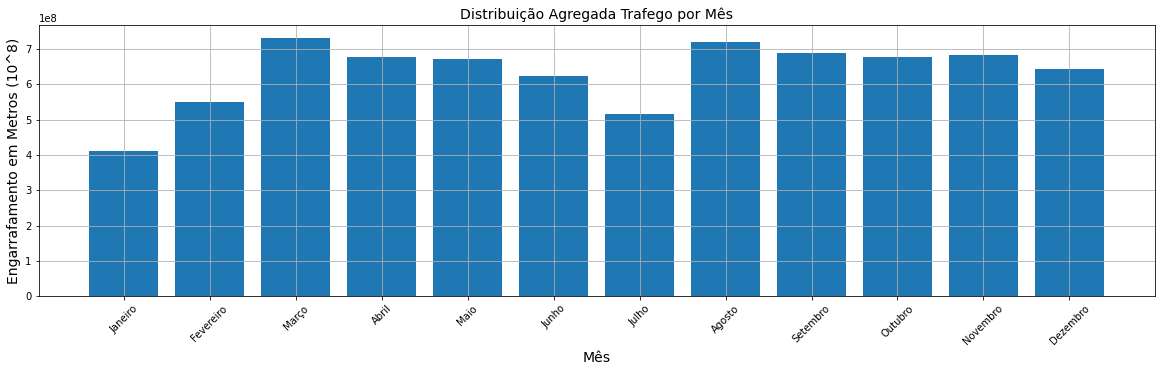

In [ ]:
# mes (Agregado)
# Somando (agregando) todos os valores de 'jam_size' em seu respectivo mês

sum_dict = {}

for key in dict_data:
  sum_dict[key] = sum(dict_data[key])


name_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril',
            'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
Ax = name_mes
Ay = sum_dict.values()

# Plotando o grafico de barras
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(Ax, Ay)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Distribuição Agregada Trafego por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Engarrafamento em Metros (10^8)', fontsize=14)
plt.grid(True)
plt.show()

**Observando a plotagem do gráfico acima é possível extrair que o menor fluxo de veículos esta no mês de Janeiro e Julho. Isto pode ser explicado pelo fato destes meses serem os mais escolhidos para as férias.**

In [ ]:
### Dia da Semana
# Pegando a data e convertendo em dia da semana

df_categ_Encoder['data'] =  pd.to_datetime(df_categ_Encoder['data'])

df_categ_Encoder['data'] =  pd.to_datetime(df_categ_Encoder['data'], format='%d%b%Y:%H:%M:%S.%f')

df_categ_Encoder['day_of_week'] = df_categ_Encoder['data'].dt.day_name()

In [ ]:
## Criando um dicionario e coletando todos os valores de 'jam_size' em um determinado dia da semana

vet_toFind = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dict_week = {}

for day_week in vet_toFind:
  find = df_categ_Encoder.loc[df_categ_Encoder['day_of_week'] == day_week]
  vet_loop = []

  for i in find['jam_size']:
    vet_loop.append(i)

  dict_week[str(day_week)] = vet_loop

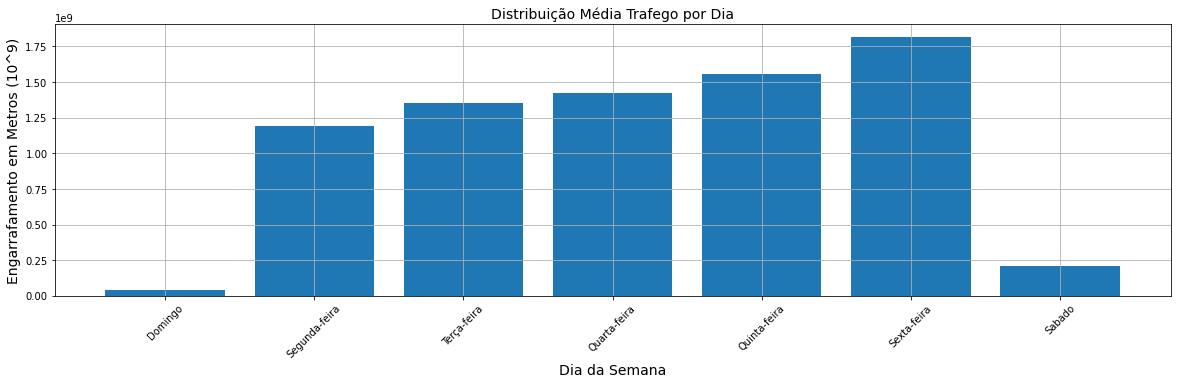

In [ ]:
# dia
# Somando (agregando) todos os valores de 'jam_size' em seu respectivo dia da semana

week_dict = {}

for key in dict_week:
  week_dict[key] = sum(dict_week[key]) # teste

dia_semana = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira',
            'Quinta-feira', 'Sexta-feira', 'Sabado']

#Ax = week_dict.keys()
Ax = dia_semana # teste
Ay = week_dict.values()

# Plotando o grafico de barras
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(Ax, Ay)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Distribuição Média Trafego por Dia', fontsize=14)
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Engarrafamento em Metros (10^9)', fontsize=14)
plt.grid(True)
plt.show()

**Observando a plotagem do gráfico acima é possível extrair que o maior fluxo de veículos esta nos dias úteis da semana, tendo seu pico na sexta-feira.**

In [ ]:
### Hora
## Criando um dicionario e coletando todos os valores de 'jam_size' em uma determinada hora

test_dict = {}  # Criando um dicionario

for hour in range(24):
  if hour < 10:
    # Encontrar horas terminadas em 0h:00:00 
    find = new_df.loc[new_df['hora'] == '0' + str(hour) + ':' + '00:00'] # Filtrando o DF para horas expecificas
    vet_test = [] # Crindo uma lista
    
    # Fazendo um loop 
    for i in find['jam_size']:
      vet_test.append(i)      
    
    # Adicionando Key e Lista no dicionario criado acima
    test_dict['0' + str(hour) + ':' + '00:00'] = vet_test    
    
    # ==================

    # Encontrar horas terminadas em 0h:30:00 
    find_2 = new_df.loc[new_df['hora'] == '0' + str(hour) + ':' + '30:00'] # Filtrando o DF para horas expecificas
    vet_test_2 = [] # Crindo uma lista

    # Fazendo um loop 
    for k in find_2['jam_size']:
      vet_test_2.append(k)      
    
    # Adicionando Key e Lista no dicionario criado acima
    test_dict['0' + str(hour) + ':' + '30:00'] = vet_test_2

  else:
    # Encontrar horas terminadas em hh:00:00 
    find = new_df.loc[new_df['hora'] == str(hour) + ':' + '00:00'] # Filtrando o DF para horas expecificas
    vet_test = [] # Crindo uma lista
    
    # Fazendo um loop 
    for i in find['jam_size']:
      vet_test.append(i)      
    
    # Adicionando Key e Lista no dicionario criado acima
    test_dict[str(hour) + ':' + '00:00'] = vet_test    
    
    # ==================

    # Encontrar horas terminadas em hh:30:00 
    find_2 = new_df.loc[new_df['hora'] == str(hour) + ':' + '30:00'] # Filtrando o DF para horas expecificas
    vet_test_2 = [] # Crindo uma lista

    # Fazendo um loop 
    for k in find_2['jam_size']:
      vet_test_2.append(k)      
    
    # Adicionando Key e Lista no dicionario criado acima
    test_dict[str(hour) + ':' + '30:00'] = vet_test_2

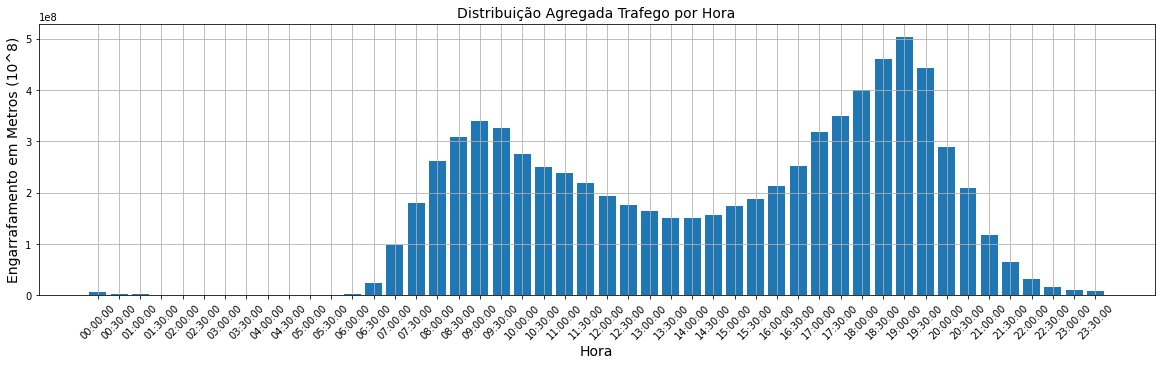

In [ ]:
# Hora (agregado)
# Somando (agregando) todos os valores de 'jam_size' em sua respectiva hora

sum_dict = {}

for key in test_dict:
  sum_dict[key] = sum(test_dict[key])

Ax = sum_dict.keys()
Ay = sum_dict.values()

# Plotando o grafico de barras
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(Ax, Ay)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Distribuição Agregada Trafego por Hora', fontsize=14)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Engarrafamento em Metros (10^8)', fontsize=14)
plt.grid(True)
plt.show()

**Observando a plotagem do gráfico acima é possível extrair que o maior fluxo de veículos esta entre as 6:30 e 21:30, tendo seus picos 9:00 e 19:00.**

In [ ]:
df_categ_Encoder.to_csv('dataframe_Encod.csv', index=False)
df_categ_Encoder.to_feather('dataframe_Encod.feather')

In [ ]:
df_categ_Encoder

,index,passage_Encod,direction_Encod,type_Encod,region_Encod,timestamp,jam_size,jam_size_Encod,segment_Encod,data,hora,hora_Encod,data_Encod,ano,mes,dia,day_of_week
0,0,153,101,2,3,2015-01-04 14:30:00,799,748,99695,2015-01-04,14:30:00,29,4745,2015,01,04,Sunday
1,1,151,29,2,5,2015-01-04 14:30:00,260,209,533,2015-01-04,14:30:00,29,4745,2015,01,04,Sunday
2,2,153,101,2,3,2015-01-04 15:00:00,799,748,99695,2015-01-04,15:00:00,30,4745,2015,01,04,Sunday
3,3,151,29,2,5,2015-01-04 15:00:00,260,209,533,2015-01-04,15:00:00,30,4745,2015,01,04,Sunday
4,4,153,101,2,3,2015-01-04 15:30:00,799,748,99695,2015-01-04,15:30:00,31,4745,2015,01,04,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5223443,5223443,170,33,0,3,2018-09-30 18:30:00,3820,3769,75974,2018-09-30,18:30:00,37,6093,2018,09,30,Sunday
5223444,5223444,170,33,1,3,2018-09-30 19:00:00,4640,4587,76072,2018-09-30,19:00:00,38,6093,2018,09,30,Sunday
5223445,5223445,170,33,0,3,2018-09-30 19:00:00,3820,3769,75974,2018-09-30,19:00:00,38,6093,2018,09,30,Sunday
5223446,5223446,170,33,1,3,2018-09-30 19:30:00,4640,4587,76072,2018-09-30,19:30:00,39,6093,2018,09,30,Sunday


# Parte 2 - Predição de engarrafamento

**Para o treinamento do classificador, será utilizado o dataset fornecido pela empresa. Cmo foi observado anteriormente o menor valor da coluna 'jam_size' (responsavel por informar o tamanho do congestionamento em metros) é 51, ou seja, o banco não fornece exemplos de quando não há congestionamento. Portando, foi adotado e criado uma coluna 'engarraf' que indica 1 quando 'não tem engarrafamento' e 2 quando engarrafamento. Os criterios para a escolha de quando não existe engarrafamento é quando o 'jam_size' é menor ou igual a 400 metros em uma rua/avenida.**

## **K-Means:**

O K-Means é um algoritmo do tipo não supervisionado, ou seja, que não trabalha com dados rotulados. O objetivo desse algoritmo é encontrar similaridades entre os dados e agrupá-los conforme o número de cluster passado pelo argumento "k".

**Para o treinamento do classificador, será utilizado o dataset fornecido pela empresa. E como foi observado anteriormente o menor valor da coluna 'jam_size' (responsavel por informar o tamanho do congestionamento em metros) é 51, ou seja, o banco não fornece exemplos de quando não há congestionamento. Portando, foi adotado e criado uma coluna 'engarraf' que indica 0 quando 'não tem engarrafamento' e 1 quando engarrafamento. Os criterios para a escolha de quando não existe engarrafamento é quando o 'jam_size' é menor ou igual a 400 metros em uma rua/avenida.**

In [ ]:
banco = pd.DataFrame()

banco['passage'] = df_categ_Encoder['passage_Encod']
banco['hora'] = LE.fit_transform(df_categ_Encoder['hora'])

In [ ]:
# Gerando coluna responsavel por informa se existe ou não engarrafamento

vet_engarraf = []

for i in df_categ_Encoder['jam_size']:
  i = int(i)
  if i <= 400:
    engarraf = 0
    vet_engarraf.append(engarraf)
  else:
    engarraf = 1
    vet_engarraf.append(engarraf)

banco['engarraf'] = vet_engarraf
banco = shuffle(banco)

In [ ]:
# Fazendo a separação do banco em treino (80%) e teste (20%)

teste = []
banco = shuffle(banco)

find_0 = banco.loc[banco['engarraf'] == 0]
find_1 = banco.loc[banco['engarraf'] == 1]

tamTrain_0 = len(find_0) * .8
tamTrain_1 = len(find_1) * .8

training_samples_0 = int(len(find_0) * .8)
validation_samples_0 = len(find_0) - training_samples_0


training_samples_1 = int(len(find_1) * .8)
validation_samples_1 = len(find_1) - training_samples_1

In [ ]:
train_get_0 = find_0[:training_samples_0]
val_get_0 = find_0[training_samples_0:training_samples_0 + validation_samples_0]

train_get_1 = find_1[:training_samples_1]
val_get_1 = find_1[training_samples_1:training_samples_1 + validation_samples_1]

In [ ]:
frames = [train_get_0, train_get_1]

df_train_full = pd.concat(frames)
df_train_full = shuffle(df_train_full)
#df_train_full.to_csv('banco_treino.csv', index=False)

In [ ]:
frames = [val_get_0, val_get_1]

df_val_full = pd.concat(frames)
df_val_full = shuffle(df_val_full)
#df_val_full.to_csv('banco_val.csv', index=False)

In [ ]:
# Separando o banco de dados.

X_train = np.array(df_train_full.drop(['engarraf'], 1).astype(float))
X_val = np.array(df_val_full.drop(['engarraf'], 1).astype(float))

In [ ]:
# Separando o banco de dados.

y_train = np.array(df_train_full['engarraf'])
y_val = np.array(df_val_full['engarraf'])

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

In [ ]:
# Treinando o modelo

kmeans = KMeans(n_clusters=2, max_iter=1200, algorithm = 'auto')
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1200,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Salvando o modelo
pickle.dump(kmeans, open("kmeans_2.pkl", "wb"))

In [ ]:
# Carregando o modelo
model = pickle.load(open("kmeans_2.pkl", "rb"))

**Gerando as métricas**

In [ ]:
## Acuracia: Acurácia: indica uma performance geral do modelo. Dentre todas as 
## classificações, quantas o modelo classificou corretamente.

pred = []
correct = 0
for i in range(len(X_val)):
    predict_me = np.array(X_val[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = model.predict(predict_me)
    pred.append(prediction[0])
    if prediction[0] == y_val[i]:
        correct += 1

print(correct/len(X_val))

0.14920201284398926


In [ ]:
## Criando um dataframe e salvando os resultados.
dados_saida = pd.DataFrame()

dados_saida['Real'] = y_val
dados_saida['Pred'] = pred

In [ ]:
## Calculando a precisão/precision, recall e f_score

# Precisão/Precision: dentre todas as classificações de classe Positivo que o 
#                     modelo fez, quantas estão corretas.

# Recall: dentre todas as situações de classe Positivo como valor esperado, 
#         quantas estão corretas;

# Fscore: média harmônica entre precisão e recall.

precision, recall, fscore, teste = precision_recall_fscore_support(dados_saida['Real'], dados_saida['Pred'], average='macro')

In [ ]:
# Salvando as metricas no dataframe criado.

dados_saida['Precison'] = precision
dados_saida['Recall'] = recall
dados_saida['fscore'] = fscore

dados_saida.to_csv('dados_saida_kmeans_2.csv', index=False)

In [ ]:
# Calculo da matriz de confusão.

cm = confusion_matrix(dados_saida['Real'], dados_saida['Pred'])

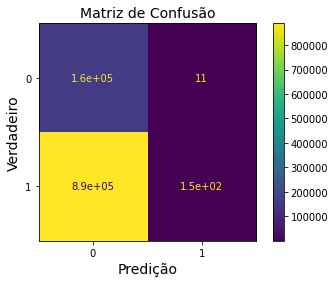

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()

plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)
plt.show()

**Esta técnica obteve uma acuracia de 14,92%, precisão de 54,04% e um recall de 50%. Mostrando-se limitada para a devida classificação.**

## **Random Forest Classifier:**

A floresta aleatória ou floresta de decisão aleatória é um algoritmo de aprendizado de máquina supervisionado usado para classificação.

In [ ]:
# Criando o banco de dados

banco_ = pd.DataFrame()

banco_['passage'] = df_categ_Encoder['passage_Encod']
banco_['hora'] = LE.fit_transform(df_categ_Encoder['hora'])

**Para o treinamento do classificador, será utilizado o dataset fornecido pela empresa. E como foi observado anteriormente o menor valor da coluna 'jam_size' (responsavel por informar o tamanho do congestionamento em metros) é 51, ou seja, o banco não fornece exemplos de quando não há congestionamento. Portando, foi adotado e criado uma coluna 'engarraf' que indica 1 quando 'não tem engarrafamento' e 2 quando engarrafamento. Os criterios para a escolha de quando não existe engarrafamento é quando o 'jam_size' é menor ou igual a 400 metros em uma rua/avenida.**

In [ ]:
# Gerando coluna responsavel por informa se existe ou não engarrafamento

vet_engarraf = []

for i in df_categ_Encoder['jam_size']:
  i = int(i)
  if i <= 400:
    engarraf = 1
    vet_engarraf.append(engarraf)
  else:
    engarraf = 2
    vet_engarraf.append(engarraf)

banco_['engarraf'] = vet_engarraf
banco_ = shuffle(banco)

In [ ]:
# Os 'labels' são os valores que queremos prever
labels = np.array(banco_['engarraf'])

# Remove os labels das 'features', axis 1 refere-se às colunas
features = banco_.drop('engarraf', axis = 1)

# Salva os nomes das features para uso posterior
feature_list = list(features.columns)

# Converte para numpy array
features = np.array(features)

In [ ]:
# Separa o banco de treino e teste a partir da função do Scikit-Learn
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3917586, 2)
Training Labels Shape: (3917586,)
Testing Features Shape: (1305862, 2)
Testing Labels Shape: (1305862,)


In [ ]:
# Treinando o modelo.

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_leaf_nodes=16)
rnd_clf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Salvando o modelo
pickle.dump(rnd_clf, open("RandomForestClass.pkl", "wb"))

In [ ]:
# Carregando o modelo
model = pickle.load(open("RandomForestClass.pkl", "rb"))

In [ ]:
# Fazendo a predição/classificação
y_pred_rf = model.predict(test_features)

In [ ]:
# Calculando o erro medio absoluto em porcentagem
mape = 100 * (errors / test_labels)
# Calculando a acuracia
accuracy = 100 - np.mean(mape)
# Exibindo a acuracia
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.21 %.


In [ ]:
t = []
for i in y_pred_rf:
  t.append(i)

In [ ]:
j = []
for i in test_labels:
  j.append(i)

In [ ]:
# Gerando o dataframe que ira armazenar os resultados

result_class = pd.DataFrame()

result_class['Real'] = j
result_class['Pred'] = t

In [ ]:
## Calculando a precisão/precision, recall e f_score

# Precisão/Precision: dentre todas as classificações de classe Positivo que o 
#                     modelo fez, quantas estão corretas.

# Recall: dentre todas as situações de classe Positivo como valor esperado, 
#         quantas estão corretas;

# Fscore: média harmônica entre precisão e recall.

precision, recall, fscore, support = precision_recall_fscore_support(result_class['Real'], result_class['Pred'], average='macro')

In [ ]:
result_class = pd.read_csv('/content/result_class.csv')

In [ ]:
cm = confusion_matrix(result_class['Real'], result_class['Pred'])

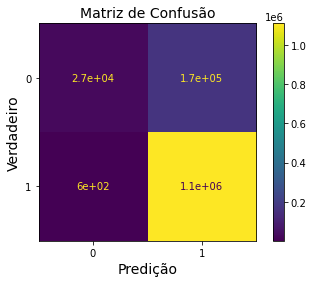

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1','2'])
disp.plot()

plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)
plt.show()

In [ ]:
result_class['Precision'] = precision
result_class['recall'] = recall
result_class['fscore'] = fscore

result_class.to_csv('result_class.csv', index=False)

**Esta técnica obteve uma acuracia de 87.21%, precisão de 92,40% e um recall de 57,01%. Mostrando-se uma possivel solução para a devida classificação.**